In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, callbacks, utils

# from https://www.kaggle.com/datasets/hmohamedhussain/leaves-image-dataset/data

train_dataset = utils.image_dataset_from_directory(
    'C:/Users/dev/notebooks/assets/leaves/train',
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = utils.image_dataset_from_directory(
    'C:/Users/dev/notebooks/assets/leaves/validation',
    image_size=(224, 224),
    batch_size=32
)

test_dataset = utils.image_dataset_from_directory(
    'C:/Users/dev/notebooks/assets/leaves/test',
    image_size=(224, 224),
    batch_size=32
)

Found 4274 files belonging to 12 classes.
Found 110 files belonging to 12 classes.
Found 110 files belonging to 12 classes.


In [2]:
# normalization thru data_augmentation
# normalization = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.2),
# ])

# normalization thru scaling
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE).map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE).map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE).map(lambda x, y: (normalization_layer(x), y))

# Create a sequential model
model = models.Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(layers.Flatten())

# Add fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))  # 12 classes for classification

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [3]:
# Train and fit the model
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Number of epochs to wait for improvement
    restore_best_weights=True # Restore weights from the best epoch
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5
134/134 [==============================] - 173s 1s/step - loss: 1.3427 - accuracy: 0.5442 - val_loss: 1.2300 - val_accuracy: 0.6273
Epoch 2/5
134/134 [==============================] - 179s 1s/step - loss: 0.5367 - accuracy: 0.8322 - val_loss: 0.9684 - val_accuracy: 0.8182
Epoch 3/5
134/134 [==============================] - 173s 1s/step - loss: 0.2946 - accuracy: 0.9097 - val_loss: 0.7652 - val_accuracy: 0.8545
Epoch 4/5
134/134 [==============================] - 171s 1s/step - loss: 0.2168 - accuracy: 0.9338 - val_loss: 0.7058 - val_accuracy: 0.8364
Epoch 5/5
134/134 [==============================] - 182s 1s/step - loss: 0.1861 - accuracy: 0.9429 - val_loss: 1.0089 - val_accuracy: 0.8273


In [6]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print('\nTest accuracy:', test_acc)

new_image = image.load_img(
    'assets/pomegranate.jpg', 
    target_size=(224, 224)  # Match model's input size
)
new_image_array = image.img_to_array(new_image)
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension
new_image_array = new_image_array / 255.0  # Normalize (if your training data was normalized)

4/4 [==============================] - 1s 266ms/step - loss: 1.4241 - accuracy: 0.8000

Test accuracy: 0.800000011920929


1/1 [==============================] - 0s 45ms/step
[[6.8813567e-03 2.2840421e-04 1.3203424e-04 7.6433490e-03 1.4202445e-04
  1.1542493e-05 5.5877605e-05 6.5587666e-03 7.8735156e-03 6.4531027e-04
  9.6974641e-01 8.1456885e-05]]
Predicted Class: [10]
Predicted Label: ['Pomegranate']


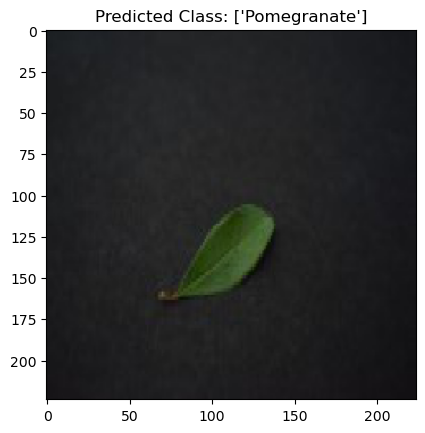

In [7]:
# Get predictions
predictions = model.predict(new_image_array)
print(predictions)

predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted Class: {predicted_class}")

class_labels = np.array(["Alstonia Scholaris", "Arjun", "Bael", "Basil", "Chinar",  "Guava", "Jamun", "Jatropha", "Lemon", "Mango", "Pomegranate", "Pongamia Pinnata"])
predicted_label = class_labels[predicted_class]
print(f"Predicted Label: {predicted_label}")

plt.imshow(new_image, cmap='gray')
plt.title(f'Predicted Class: {predicted_label}')
plt.show()